In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score
import random
from sklearn.ensemble import RandomForestClassifier

In [41]:
from joblib import load

# Load x,y and models
loaded_models = load('models.joblib') 

# Access individual models
random_forest_model = loaded_models['RandomForest']


loaded_data = load('train_test_data.joblib')

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']

In [43]:
# Helper function to ensure gamma is either 'scale', 'auto', or a positive number 
def get_valid_gamma():
    # Ensures that gamma is either 'scale', 'auto', or a positive number
    gamma_value = np.random.uniform(-5, 5)  # Ggenerating a random value, but it may be invalid
    if gamma_value < 0:  # If gamma is negative, choose between 'scale' and 'auto'
        return np.random.choice(['scale', 'auto'])
    else:
        return max(0.0, gamma_value)  

In [44]:
# Fitness function: evaluates SVM performance based on parameters
# params[0] = C, params[1] = gamma

def fitness_functionn(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
                class_weight={0: 1, 1: (1 - y_train.mean())/y_train.mean()},
                n_jobs=-1,
                random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')

In [45]:
def fitness_function(params, X_train, y_train, X_test, y_test):
    C = params[0]
    gamma = get_valid_gamma() 

    try:
        # Initializing the SVC classifier with parameters
        model = RandomForestClassifier(
                class_weight={0: 1, 1: (1 - y_train.mean())/y_train.mean()},
                n_jobs=-1,
                random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return accuracy_score(y_test, y_pred)
    except Exception as e:
        print("Error in the model:", e)
        return 0

### GENETIC ALGORITHM ###

In [46]:
def genetic_algorithm(fitness_func, population_size=10, generations=20, mutation_rate=0.2):
    population = [np.random.uniform(0.1, 100, size=2) for _ in range(population_size)]
    best_scores = []

    for gen in range(generations):
        scores = [fitness_func(ind) for ind in population]
        best_scores.append(np.max(scores))

        # Selection: Top 50%
        sorted_indices = np.argsort(scores)[::-1]
        selected = [population[i] for i in sorted_indices[:population_size // 2]]

        # Crossover + Mutation
        children = []
        while len(children) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            crossover = np.array([
                parent1[0] if random.random() < 0.5 else parent2[0],
                parent1[1] if random.random() < 0.5 else parent2[1]
            ])
            if random.random() < mutation_rate:
                mutation = np.random.uniform(-1, 1, size=2)
                crossover += mutation
            crossover = np.clip(crossover, 0.1, 100)
            children.append(crossover)
        population = children

    best_params = population[np.argmax(scores)]
    return best_params, best_scores

### PARTICLE SWARM OPTIMIZATION ###

In [47]:
def particle_swarm_optimization(fitness_func, swarm_size=10, iterations=20):

    # Initialization of particles
    particles = [np.random.uniform(0.1, 100, size=2) for _ in range(swarm_size)]
    velocities = [np.zeros(2) for _ in range(swarm_size)]
    personal_best = particles.copy()
    global_best = particles[0]

    # Fitness assessment for initial particles
    global_best_score = fitness_func(global_best)
    scores_history = []

    for _ in range(iterations):
        for i, particle in enumerate(particles):
            score = fitness_func(particle)
            if score > fitness_func(personal_best[i]):
                personal_best[i] = particle
            if score > global_best_score:
                global_best = particle
                global_best_score = score
        scores_history.append(global_best_score)

        # Updating particle velocities and positions
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (0.5 * velocities[i] +
                             r1 * (personal_best[i] - particles[i]) +
                             r2 * (global_best - particles[i]))
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0.1, 100)

    return global_best, scores_history

### ARTIFICIAL IMMUNE SYSTEM ###

In [48]:
def artificial_immune_system(fitness_func, population_size=10, generations=20, clone_factor=5):
    antibodies = [np.random.uniform(0.1, 100, size=2) for _ in range(population_size)]
    best_scores = []

    for _ in range(generations):
        clone_pool = []

        # Cloning of antibodies
        for ab in antibodies:
            clones = [ab + np.random.normal(0, 5, size=2) for _ in range(clone_factor)]
            clones = [np.clip(cl, 0.1, 100) for cl in clones]
            clone_pool.extend(clones)

        clone_scores = [fitness_func(params) for params in clone_pool]
        top_indices = np.argsort(clone_scores)[-population_size:]
        antibodies = [clone_pool[i] for i in top_indices]
        best_scores.append(max(clone_scores))

    best_ab = antibodies[np.argmax([fitness_func(ab) for ab in antibodies])]
    return best_ab, best_scores


 Let us run all optimizers

In [ ]:
print("Running Genetic Algorithm...")
ga_params, ga_scores = genetic_algorithm(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

print("Running PSO...")
pso_params, pso_scores = particle_swarm_optimization(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

print("Running AIS...")
ais_params, ais_scores = artificial_immune_system(lambda p: fitness_function(p, X_train, y_train, X_test, y_test))

Running Genetic Algorithm...
Running PSO...
Running AIS...


In [51]:
#Final evaluation
def evaluate_model(params):
    model = RandomForestClassifier(
                class_weight={0: 1, 1: (1 - y_train.mean())/y_train.mean()},
                n_jobs=-1,
                random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1_score': f1_score(y_test, y_pred, average='macro')
    }

In [ ]:
ga_eval = evaluate_model(ga_params)
pso_eval = evaluate_model(pso_params)
ais_eval = evaluate_model(ais_params)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Default SVM model with default parameters
default = random_forest_model  # Using all default parameters (C=1.0, gamma='scale')

# Make predictions
y_pred = default.predict(X_test)

# Calculate metrics
default_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1_score': f1_score(y_test, y_pred, average='macro')
}

# Display results
print("Default SVM Model Metrics (Before Optimization):")
print(f"Accuracy: {default_metrics['accuracy']:.4f}")
print(f"Recall: {default_metrics['recall']:.4f}")
print(f"F1 Score: {default_metrics['f1_score']:.4f}")

Default Random Forest Model Metrics (Before Optimization):
Accuracy: 0.9799
Recall: 0.7235
F1 Score: 0.7994


In [ ]:
# Evaluation results
results = {
    "Algorithm": ["Default SVM", "Genetic Algorithm", "Particle Swarm Optimization", "Artificial Immune System"],
    "Accuracy": [default_metrics["accuracy"], ga_eval["accuracy"], pso_eval["accuracy"], ais_eval["accuracy"]],
    "Recall": [default_metrics["recall"], ga_eval["recall"], pso_eval["recall"], ais_eval["recall"]],
    "F1 Score": [default_metrics["f1_score"], ga_eval["f1_score"], pso_eval["f1_score"], ais_eval["f1_score"]],
}

df_results = pd.DataFrame(results)

print("\nFinal Performance Metrics:\n")
print(df_results.to_string(index=False))



Final Performance Metrics:

                  Algorithm  Accuracy   Recall  F1 Score
                Default SVM  0.979894 0.723501  0.799427
          Genetic Algorithm  0.983234 0.783205  0.852335
Particle Swarm Optimization  0.989323 0.773223  0.813445
   Artificial Immune System  0.985422 0.762344  0.832427


In [ ]:
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, roc_auc_score

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Get predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Store metrics
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'average_precision': average_precision_score(y_test, y_prob)
        }
        
        # Print summary
        print(f"\n{name} Performance:")
        print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
        print(f"Avg Precision: {results[name]['average_precision']:.4f}")
        print("Confusion Matrix:")
        print(results[name]['confusion_matrix'])
    
    return results

evaluate_models(random_forest_model, X_test, y_test)

Genetic Algorithm Performance:
ROC AUC: 0.9348
Avg Precision: 0.7453
Confusion Matrix:
[[172797    139]
 [   384   1388]]


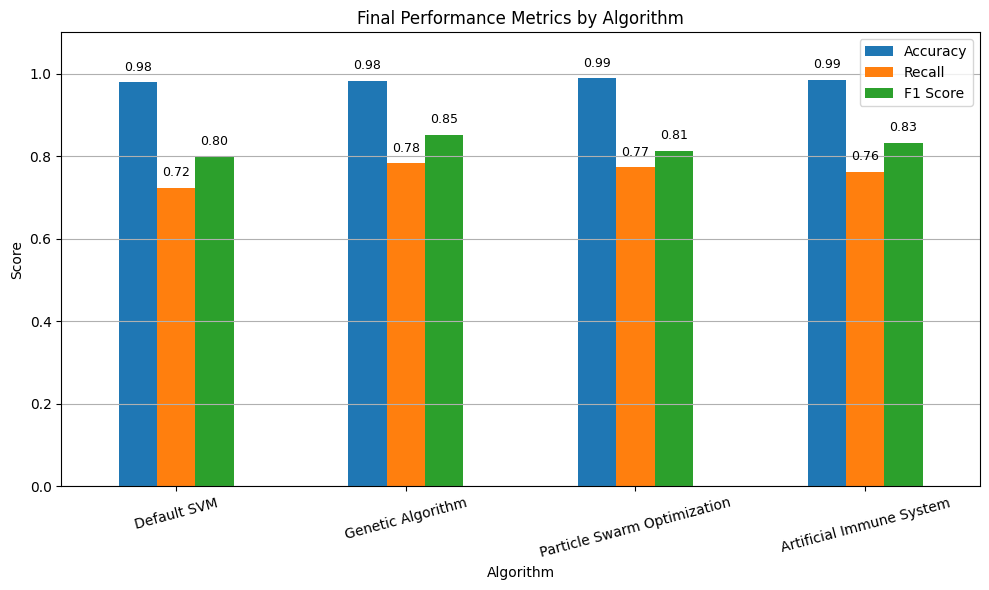

In [ ]:
ax = df_results.set_index("Algorithm").plot(kind="bar", figsize=(10, 6))
plt.title("Final Performance Metrics by Algorithm")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            height + 0.02,                      
            f"{height:.2f}",                    
            ha='center', va='bottom', fontsize=9
        )

plt.show()
